# Trading at the Close - Hyperparameter Optimization
-----------------------
-----------------------


This notebook is intended to be run after the preprocessing notebook. Provided that LGBM does a good job in fitting this dataset, we'll use the LGBMRegressor and Optuna to find good hyperparameters.

## Installs
-------------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import numpy as np
from pathlib import Path
from loguru import logger
from pprint import pformat
import pandas as pd
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from IPython.display import clear_output
import optuna
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import MedianPruner, HyperbandPruner
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
)

from utils.validation import TrainTestSplit

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("ticks")

c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-tuning_lgbmregressor"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    FEATURES_PATH = JOBS_PATH.joinpath("optiver-feature_selection-0009")
    FEATURES_NAME = "feature_names.json"
    BEST_PARAMS = "best_params.json"
    RANDOM_STATE = 42
    USE_GPU = False
    MODEL = LGBMRegressor
    CROSSVAL = TrainTestSplit
    SHUFFLE = True
    SAMPLER = CmaEsSampler
    PRUNER = HyperbandPruner
    USE_BEST = False
    JOB_PATH_BEST = JOBS_PATH.joinpath("optiver-tuning_lgbmregressor-0008")
    HYPERTUNE = True
    PRELOAD_STUDY = False
    TEST_SIZE = 45
    N_FOLDS = 3
    N_TRIALS = 50
    N_JOBS = 3

In [4]:
def lgbm_param_space(trial):
    """Returns the parameter space of a LGBMRegressor."""
    # num_leaves should be smaller than 2^{max_depth}
    max_depth = trial.suggest_int("max_depth", 5, 12)
    num_leaves = trial.suggest_int("num_leaves", 8, int((2**max_depth) * 0.75))
    #num_leaves = trial.suggest_int("num_leaves", 8, 64)

    param_space = {
        "device": trial.suggest_categorical("device", ["gpu" if CFG.USE_GPU else "cpu"]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "n_jobs": trial.suggest_categorical("n_jobs", [1]),
        "objective": trial.suggest_categorical("objective", ["mae"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [750]), # automatically via early stopping
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "num_leaves": num_leaves,
        "max_depth": max_depth
    }

    return param_space



def lgbm_callbacks(trial):
    """Returns the callbacks for a LGBMRegressor."""
    optuna_prune = optuna.integration.LightGBMPruningCallback(trial, "l1", report_interval=100)
    inner_early_stop = lgb.early_stopping(25, verbose=False)

    return [inner_early_stop]
    #return [optuna_prune, inner_early_stop]


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "param_space": lgbm_param_space,
        "callbacks": lgbm_callbacks
    }
}  

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Data Loading
---------------

In the next cell, we define code to load the data and to generate features with optional memory reduction. It uses functions that are written to file by running `%%writefile` in `preprocessing.ipynb`.

In [6]:
from utils.features import make_features, select_features, make_rolling_features
from utils.aggregations import aggregate, apply_aggregations
from utils.cleaning import clean as clean_dataset
from utils.files import read_json

df = pd.read_csv(CFG.TRAINING_PATH)
features = read_json(CFG.FEATURES_PATH.joinpath(CFG.FEATURES_NAME))
selected_features = features["selected_features"]
stock_weights = features["stock_weights"]

# Get standard features
df = make_features(df, reduce_memory=True)

# Create aggregations
_, aggregations = aggregate(df, stock_weights)
df = apply_aggregations(df, aggregations_date=aggregations, reduce_memory=True)

# Get rolling features
df = make_rolling_features(df, reduce_memory=True)

# Select features
selected_features.extend(["date_id"])
df = select_features(df, selected_features, reduce_memory=False)

# Clean dataset
clean_dataset(df)

# Separate features from dependent variable
date_id = df["date_id"]
df.drop(columns=["date_id"], inplace=True)

Y = df["target"]
X = df.drop(columns=["target"], errors="ignore")

del df

2023-10-28 00:18:30.278 | INFO     | utils.features:make_features:25 - Creating additional features...
2023-10-28 00:19:14.616 | INFO     | utils.features:make_features:75 - Reducing data memory footprint...
2023-10-28 00:19:14.626 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 3117.08 MB
2023-10-28 00:19:39.789 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 2143.00 MB
2023-10-28 00:19:39.791 | INFO     | utils.compression:downcast:27 - Decreased by 31.25%
2023-10-28 00:20:52.005 | INFO     | utils.aggregations:apply_aggregations:127 - Applying date-wise aggregations...
2023-10-28 00:21:19.775 | INFO     | utils.aggregations:apply_aggregations:135 - Reducing data memory footprint...
2023-10-28 00:21:19.775 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 2742.43 MB
2023-10-28 00:21:41.733 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 2502.66 MB
2023-10-28 00:21:41.75

## Hyperparameter Optimization
-----------------------------------

### Setup the evaluation process

We have many options, but we'll stick with cross-validation schemes even though these are more expensive to tune. This is because it yields more robust estimations of mean absolute error.


In [7]:
from utils.validation import cross_validate

### Optimization specifics

We define a convenience function `run_optimization`, that starts the optimization process given a objective function.

The objective function is returned by the `get_objective_function` method. Inside this method, the parameter space is defined using the optuna `trial` object.

In [8]:
# Optimization runner
def run_optimization(objective, n_trials=100, sampler=TPESampler(), pruner=MedianPruner(), n_jobs=1, best_trial=None):
    """Run the given objective with Optuna and return the study results."""

    study_name = "optuna-study"
    storage = "sqlite:///" + str(CFG.JOB_PATH.joinpath(study_name)) + ".sqlite3"
    logger.info(f"Creating study...")


    if CFG.PRELOAD_STUDY:
        study = optuna.load_study(
            study_name=study_name, 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

    else:
        try:
            optuna.study.delete_study(
                study_name=study_name,
                storage=storage
            )
        except:
            logger.warning(f"Study does not exist...")

        study = optuna.create_study(
            study_name=study_name, 
            direction="minimize", 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

    if best_trial is not None:
        logger.info("Enqueuing previous best trial ...")
        study.enqueue_trial(best_trial)

    logger.info(f"Running hyperparameter search...")
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=True)

    logger.info(f"Number of finished trials: {len(study.trials)}")
    logger.success(f"Best MAE: {study.best_value:.4f}")

    logger.info("Parameters: ")
    logger.info("=" * 10)
    logger.success(pformat(study.best_params, indent=4))

    logger.info(f"Saving best parameters...")
    with open("best_params.json", "w") as f:
        json.dump(study.best_params, f)
    return study

In [9]:
def get_objective_function(model_cls, param_func, x, y, date_id, cv=TimeSeriesSplit(), callbacks_func=None, *args, **kwargs):
    """Returns the objective function for optuna."""
        
    def objective_function(trial):
        """Optimizes a model with cross-validation."""

        param_space = param_func(trial)
        callbacks = callbacks_func(trial) if callbacks_func is not None else None  
        scores, _ = cross_validate(model_cls, param_space, x, y, date_id=date_id, cv=cv, callbacks=callbacks, *args, **kwargs)
        return scores.mean()

    return objective_function

### Start the optimization

We can set these variables here:
1. `run_optimization`: Whether to run the optimization or use already computed ones.
2. `n_trials`: How many trials we want to sample.
3. `cv`: the Split object.
4. `best_trial`: whether to reuse a previously tuned best trial for this optimization.

*Warning*: `evaluation='cross_validate'` takes very long!

In [10]:
from utils.files import read_json

if CFG.USE_BEST:
    best_params = read_json(CFG.JOB_PATH_BEST.joinpath(CFG.BEST_PARAMS))

In [11]:
from utils.files import dump_json

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["param_space"]
callbacks_func = model_cfg["callbacks"]
best_trial = best_params if CFG.USE_BEST else None

clear_output(wait=True) # clears output before rerunning optimization

if CFG.HYPERTUNE:
    objective = get_objective_function(
        model_cls, 
        param_space_func, 
        X, Y, 
        date_id=date_id,
        cv=CFG.CROSSVAL(test_size=date_id.max() - CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
        categorical_feature=["imbalance_buy_sell_flag"],
        callbacks_func=callbacks_func
    )
    study = run_optimization(
        objective, 
        sampler=CFG.SAMPLER(), 
        pruner=CFG.PRUNER(), 
        n_trials=CFG.N_TRIALS, 
        n_jobs=CFG.N_JOBS, 
        best_trial=best_trial
    )
    best_params = study.best_params
    dump_json(CFG.JOB_PATH.joinpath(CFG.BEST_PARAMS), best_params, indent=4)

2023-10-28 00:22:05.115 | INFO     | __main__:run_optimization:7 - Creating study...
2023-10-28 00:22:05.575 | WARNING  | __main__:run_optimization:25 - Study does not exist...
2023-10-28 00:22:05.624 | INFO     | __main__:run_optimization:39 - Running hyperparameter search...
  0%|          | 0/50 [00:00<?, ?it/s]2023-10-28 00:22:06.511 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 00:22:06.526 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 00:22:06.558 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 00:22:06.558 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 00:22:06.573 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 00:22:06.573 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 00:22:11.934 | INFO     | utils.validation:cross_validate:91 - Mode

[W 2023-10-28 00:45:11,552] The parameter 'num_leaves' in trial#4 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 00:45:36.132 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 00:47:29.195 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8424 (took 1470.21s)
2023-10-28 00:47:42.487 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 00:50:56.531 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8511 (took 313.74s)
2023-10-28 00:51:07.055 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 00:55:16.553 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8509 (took 243.51s)
2023-10-28 00:55:26.838 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 00:59:30.095 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8508 (took 237.61s)
2023-10-28 00:59:30.151 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 00:59:30.158 | SUCCESS  | utils.validation:cross_va

[W 2023-10-28 00:59:30,716] The parameter 'num_leaves' in trial#5 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 00:59:43.102 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:00:50.796 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8473 (took 930.91s)
2023-10-28 01:01:01.071 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 01:03:33.059 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8529 (took 225.81s)
2023-10-28 01:03:43.516 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 01:07:16.645 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8496 (took 209.28s)
2023-10-28 01:07:25.374 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 01:08:39.630 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8424 (took 1219.34s)
2023-10-28 01:08:44.241 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 01:12:05.098 | INFO     | utils.validation:cross_valid

[W 2023-10-28 01:12:05,594] The parameter 'num_leaves' in trial#6 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:12:19.502 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:13:42.696 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8491 (took 741.73s)
2023-10-28 01:13:42.752 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:13:42.752 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8482 ± 0.00
2023-10-28 01:13:42.758 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 1. Best value: 5.8472:  10%|█         | 5/50 [51:37<6:37:58, 530.64s/it]2023-10-28 01:13:43.307 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 01:13:43.307 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 01:13:43,208] The parameter 'num_leaves' in trial#7 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:13:55.495 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:19:16.299 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8469 (took 404.81s)
2023-10-28 01:19:27.118 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 01:21:38.042 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8492 (took 451.79s)
2023-10-28 01:21:48.681 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 01:26:35.957 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8467 (took 415.72s)
2023-10-28 01:26:46.617 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 01:27:46.915 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8434 (took 1111.93s)
2023-10-28 01:27:46.915 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:27:46.924 | SUCCESS  | utils.validation:cross_va

[W 2023-10-28 01:27:47,720] The parameter 'num_leaves' in trial#8 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:28:00.432 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:30:50.165 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8455 (took 527.29s)
2023-10-28 01:31:01.095 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 01:33:09.837 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8493 (took 303.80s)
2023-10-28 01:33:20.518 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 01:33:47.677 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8483 (took 408.38s)
2023-10-28 01:33:47.733 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:33:47.739 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8473 ± 0.00
2023-10-28 01:33:47.742 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 2. Best value: 5.84273:  14%|█▍        | 7/50 [1:1

[W 2023-10-28 01:33:48,278] The parameter 'num_leaves' in trial#9 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:34:01.869 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:39:00.872 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8458 (took 467.58s)
2023-10-28 01:39:00.919 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:39:00.929 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8469 ± 0.00
2023-10-28 01:39:00.929 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 2. Best value: 5.84273:  16%|█▌        | 8/50 [1:16:56<5:30:42, 472.44s/it]2023-10-28 01:39:02.410 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 01:39:02.410 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 01:39:02,323] The parameter 'num_leaves' in trial#10 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:39:15.675 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:39:21.432 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8462 (took 350.69s)
2023-10-28 01:39:45.747 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 01:45:44.190 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8488 (took 351.80s)
2023-10-28 01:45:44.231 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:45:44.237 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8481 ± 0.00
2023-10-28 01:45:44.237 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 2. Best value: 5.84273:  18%|█▊        | 9/50 [1:23:39<5:08:04, 450.85s/it]2023-10-28 01:45:44.905 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 01:45:44.912 | INFO     | utils.validation:cross_validate:80 - ============

[W 2023-10-28 01:45:44,801] The parameter 'num_leaves' in trial#11 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:45:58.036 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 01:46:19.259 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8430 (took 712.46s)
2023-10-28 01:46:34.681 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 01:48:26.640 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8548 (took 146.72s)
2023-10-28 01:48:38.293 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 01:51:05.695 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8603 (took 145.30s)
2023-10-28 01:51:16.341 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 01:53:43.867 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8560 (took 145.54s)
2023-10-28 01:53:43.908 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 01:53:43.914 | SUCCESS  | utils.validation:cross_val

[W 2023-10-28 01:53:44,380] The parameter 'num_leaves' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 01:53:53.262 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 02:00:58.493 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8420 (took 832.83s)
2023-10-28 02:01:04.158 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8451 (took 418.82s)
2023-10-28 02:01:05.259 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 02:01:16.114 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 02:03:59.373 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8431 (took 1428.22s)
2023-10-28 02:04:12.227 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 02:10:52.817 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8454 (took 561.51s)
2023-10-28 02:11:02.329 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 02:16:45.218 | INFO     | utils.validation:cross_valid

[W 2023-10-28 02:16:45,792] The parameter 'num_leaves' in trial#13 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 02:16:58.739 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 02:19:23.350 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8437 (took 486.02s)
2023-10-28 02:19:23.398 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 02:19:23.404 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8447 ± 0.00
2023-10-28 02:19:23.405 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  24%|██▍       | 12/50 [1:57:17<5:57:19, 564.20s/it]2023-10-28 02:19:23.857 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 02:19:23.857 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 02:19:23,750] The parameter 'num_leaves' in trial#14 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 02:19:36.279 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 02:21:33.398 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8469 (took 268.45s)
2023-10-28 02:21:42.270 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 02:26:38.279 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8471 (took 289.13s)
2023-10-28 02:26:45.879 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 02:26:51.081 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8439 (took 1302.75s)
2023-10-28 02:27:09.209 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 02:32:50.732 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8468 (took 358.00s)
2023-10-28 02:32:50.783 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 02:32:50.792 | SUCCESS  | utils.validation:cross_va

[W 2023-10-28 02:32:51,522] The parameter 'num_leaves' in trial#15 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 02:33:05.226 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 02:34:07.894 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8422 (took 844.05s)
2023-10-28 02:34:17.907 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 02:41:15.385 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8443 (took 477.98s)
2023-10-28 02:41:26.170 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 02:47:53.613 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8428 (took 789.56s)
2023-10-28 02:48:03.192 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 02:49:40.361 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8449 (took 481.64s)
2023-10-28 02:49:52.784 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 02:50:47.413 | INFO     | utils.validation:cross_valida

[W 2023-10-28 02:50:48,174] The parameter 'num_leaves' in trial#16 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 02:51:01.411 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 02:59:16.733 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8449 (took 547.94s)
2023-10-28 02:59:16.782 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 02:59:16.788 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8447 ± 0.00
2023-10-28 02:59:16.790 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  30%|███       | 15/50 [2:37:11<6:43:28, 691.68s/it]2023-10-28 02:59:17.298 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 02:59:17.298 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 02:59:17,209] The parameter 'num_leaves' in trial#17 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 02:59:29.672 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:02:12.060 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8435 (took 821.29s)
2023-10-28 03:02:12.115 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 03:02:12.122 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8428 ± 0.00
2023-10-28 03:02:12.124 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  32%|███▏      | 16/50 [2:40:06<5:03:53, 536.29s/it]2023-10-28 03:02:12.767 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 03:02:12.767 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 03:02:12,663] The parameter 'num_leaves' in trial#18 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 03:02:27.039 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:03:43.135 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8452 (took 737.07s)
2023-10-28 03:03:53.634 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 03:05:42.252 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8526 (took 191.59s)
2023-10-28 03:05:53.567 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 03:07:26.905 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8536 (took 469.93s)
2023-10-28 03:07:37.613 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 03:09:30.501 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8502 (took 212.30s)
2023-10-28 03:09:41.481 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 03:13:09.868 | INFO     | utils.validation:cross_valida

[W 2023-10-28 03:13:10,419] The parameter 'num_leaves' in trial#19 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 03:13:22.367 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:19:00.265 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8428 (took 871.12s)
2023-10-28 03:19:11.505 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 03:19:12.900 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8526 (took 682.92s)
2023-10-28 03:19:43.346 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 03:22:38.359 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8448 (took 540.94s)
2023-10-28 03:22:51.792 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 03:29:02.663 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8527 (took 551.13s)
2023-10-28 03:29:02.712 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 03:29:02.721 | SUCCESS  | utils.validation:cross_val

[W 2023-10-28 03:29:03,193] The parameter 'num_leaves' in trial#20 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 03:29:17.719 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:30:38.393 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8467 (took 453.52s)
2023-10-28 03:30:50.177 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 03:38:19.697 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8428 (took 1112.28s)
2023-10-28 03:38:19.751 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 03:38:19.752 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8436 ± 0.00
2023-10-28 03:38:19.759 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  38%|███▊      | 19/50 [3:16:14<5:34:47, 647.97s/it]2023-10-28 03:38:20.364 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 03:38:20.364 | INFO     | utils.validation:cross_validate:80 - ==========

[W 2023-10-28 03:38:20,260] The parameter 'num_leaves' in trial#21 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 03:38:35.033 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:39:43.969 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8454 (took 518.43s)
2023-10-28 03:39:44.015 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 03:39:44.022 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8456 ± 0.00
2023-10-28 03:39:44.024 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  40%|████      | 20/50 [3:17:38<3:59:21, 478.70s/it]2023-10-28 03:39:44.564 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 03:39:44.564 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 03:39:44,446] The parameter 'num_leaves' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 03:39:58.057 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 03:40:35.350 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8462 (took 661.18s)
2023-10-28 03:40:47.439 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 03:49:28.978 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8465 (took 637.35s)
2023-10-28 03:49:40.267 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 03:49:45.320 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8488 (took 525.74s)
2023-10-28 03:50:22.262 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 03:58:52.184 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8466 (took 1100.30s)
2023-10-28 03:59:02.573 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 04:00:03.239 | INFO     | utils.validation:cross_valid

[W 2023-10-28 04:00:03,759] The parameter 'num_leaves' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 04:00:17.003 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 04:02:43.586 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8440 (took 762.16s)
2023-10-28 04:02:54.051 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 04:14:50.509 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8457 (took 697.92s)
2023-10-28 04:14:50.554 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 04:14:50.563 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8454 ± 0.00
2023-10-28 04:14:50.563 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  44%|████▍     | 22/50 [3:52:45<5:53:12, 756.89s/it]2023-10-28 04:14:51.060 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 04:14:51.060 | INFO     | utils.validation:cross_validate:80 - ===========

[W 2023-10-28 04:14:50,949] The parameter 'num_leaves' in trial#24 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 04:15:04.951 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 04:18:13.513 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8471 (took 1117.82s)
2023-10-28 04:18:25.957 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 04:24:31.414 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8418 (took 1395.96s)
2023-10-28 04:24:43.473 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 04:37:19.235 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8468 (took 1100.76s)
2023-10-28 04:37:19.278 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 04:37:19.286 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8468 ± 0.00
2023-10-28 04:37:19.286 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 9. Best value: 5.84232:  46%|████▌     | 23/50 

[W 2023-10-28 04:37:19,736] The parameter 'num_leaves' in trial#25 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 04:37:33.071 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 04:41:58.382 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8506 (took 261.21s)
2023-10-28 04:42:03.611 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8410 (took 1563.15s)
2023-10-28 04:42:08.284 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 04:42:08.300 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 04:46:38.823 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8556 (took 267.79s)
2023-10-28 04:46:52.418 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 04:50:17.496 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8410 (took 1474.10s)
2023-10-28 04:50:21.144 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8518 (took 205.60s)
2023-10-28 04:50:21.144 | INFO     | utils.validation:cross_va

[W 2023-10-28 04:50:21,658] The parameter 'num_leaves' in trial#26 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 04:50:28.429 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 04:50:30.948 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 04:58:14.534 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8475 (took 453.48s)
2023-10-28 04:58:28.153 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 05:08:10.901 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8431 (took 564.07s)
2023-10-28 05:08:21.670 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 05:11:41.928 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8415 (took 1714.67s)
2023-10-28 05:11:53.326 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 05:16:16.995 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8418 (took 1490.06s)
2023-10-28 05:16:17.050 | INFO     | utils.validation:cross_vali

[W 2023-10-28 05:16:17,718] The parameter 'num_leaves' in trial#27 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 05:16:31.869 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 05:16:44.867 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8450 (took 486.93s)
2023-10-28 05:16:44.926 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 05:16:44.931 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8452 ± 0.00
2023-10-28 05:16:44.932 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 23. Best value: 5.84153:  52%|█████▏    | 26/50 [4:54:39<5:08:15, 770.63s/it] 2023-10-28 05:16:45.839 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 05:16:45.839 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 05:16:45,736] The parameter 'num_leaves' in trial#28 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 05:17:11.048 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 05:20:06.327 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8627 (took 173.29s)
2023-10-28 05:20:17.306 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 05:23:17.321 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8609 (took 177.89s)
2023-10-28 05:23:26.064 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 05:26:44.756 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8606 (took 195.98s)
2023-10-28 05:26:44.784 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 05:26:44.792 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8614 ± 0.00
2023-10-28 05:26:44.793 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 23. Best value: 5.84153:  54%|█████▍    | 27/50 [5

[W 2023-10-28 05:26:45,169] The parameter 'num_leaves' in trial#29 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 05:26:54.006 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 05:36:48.004 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8468 (took 1170.15s)
2023-10-28 05:36:58.038 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 05:38:16.199 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8418 (took 1526.21s)
2023-10-28 05:38:16.254 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 05:38:16.260 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8414 ± 0.00
2023-10-28 05:38:16.260 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  56%|█████▌    | 28/50 [5:16:11<4:20:42, 711.03s/it] 

[W 2023-10-28 05:38:17,087] The parameter 'num_leaves' in trial#30 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 05:38:17.382 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 05:38:17.382 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 05:38:32.250 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 05:49:49.137 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8432 (took 656.54s)
2023-10-28 05:50:02.798 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 05:50:20.359 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8452 (took 1329.15s)
2023-10-28 05:50:39.693 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 06:00:50.684 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8471 (took 1387.38s)
2023-10-28 06:01:02.610 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 06:02:24.850 | INFO     | utils.validation:cross_validate:1

[W 2023-10-28 06:14:29,962] The parameter 'num_leaves' in trial#31 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 06:14:30.217 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 06:14:30.219 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 06:14:44.500 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 06:24:31.898 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8473 (took 1361.79s)
2023-10-28 06:24:31.950 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 06:24:31.953 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8471 ± 0.00
2023-10-28 06:24:31.953 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  60%|██████    | 30/50 [6:02:26<5:28:30, 985.54s/it] 2023-10-28 06:24:32.695 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 06:24:32.695 | INFO     | utils.validation:cross_validate:80 - ==============

[W 2023-10-28 06:24:32,590] The parameter 'num_leaves' in trial#32 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 06:24:47.633 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 06:36:33.173 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8459 (took 1328.75s)
2023-10-28 06:36:33.225 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 06:36:33.230 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8455 ± 0.00
2023-10-28 06:36:33.231 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  62%|██████▏   | 31/50 [6:14:28<4:47:00, 906.33s/it]2023-10-28 06:36:34.210 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 06:36:34.210 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 06:36:34,105] The parameter 'num_leaves' in trial#33 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 06:36:49.329 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 06:48:32.413 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8432 (took 1907.82s)
2023-10-28 06:48:44.308 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 06:52:30.238 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8421 (took 1590.55s)
2023-10-28 06:52:43.363 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 06:57:38.331 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8426 (took 1197.10s)
2023-10-28 06:57:50.585 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 07:17:42.697 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8418 (took 1145.27s)
2023-10-28 07:17:54.413 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 07:20:37.453 | INFO     | utils.validation:cross_va

[W 2023-10-28 07:38:09,269] The parameter 'num_leaves' in trial#34 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 07:38:24.159 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 07:48:32.906 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8422 (took 1590.75s)
2023-10-28 07:48:32.947 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 07:48:32.949 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8421 ± 0.00
2023-10-28 07:48:32.950 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  66%|██████▌   | 33/50 [7:26:27<6:38:46, 1407.43s/it]2023-10-28 07:48:33.810 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 07:48:33.810 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 07:48:33,706] The parameter 'num_leaves' in trial#35 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 07:48:47.970 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 07:50:38.269 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8431 (took 706.93s)
2023-10-28 07:50:50.899 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 07:54:59.926 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8452 (took 361.20s)
2023-10-28 07:55:12.406 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 07:55:59.648 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8433 (took 1870.18s)
2023-10-28 07:55:59.689 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 07:55:59.695 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8434 ± 0.00
2023-10-28 07:55:59.696 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  68%|██████▊   | 34/50 [7

[W 2023-10-28 07:56:01,154] The parameter 'num_leaves' in trial#36 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 07:56:15.245 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 08:01:05.180 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8479 (took 342.96s)
2023-10-28 08:01:16.614 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 08:01:53.228 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8438 (took 639.11s)
2023-10-28 08:02:05.195 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 08:06:56.943 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8456 (took 330.92s)
2023-10-28 08:06:56.977 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 08:06:56.987 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8462 ± 0.00
2023-10-28 08:06:56.988 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  70%|███████   | 35/50 [7:

[W 2023-10-28 08:06:57,486] The parameter 'num_leaves' in trial#37 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 08:07:10.744 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 08:07:13.909 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8436 (took 637.33s)
2023-10-28 08:07:37.455 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 08:15:06.919 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8425 (took 754.78s)
2023-10-28 08:15:06.965 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 08:15:06.969 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8431 ± 0.00
2023-10-28 08:15:06.971 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  72%|███████▏  | 36/50 [7:53:01<3:14:27, 833.36s/it]2023-10-28 08:15:07.636 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 08:15:07.636 | INFO     | utils.validation:cross_validate:80 - ===========

[W 2023-10-28 08:15:07,518] The parameter 'num_leaves' in trial#38 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 08:15:23.106 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 08:18:57.404 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8441 (took 661.57s)
2023-10-28 08:19:09.549 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 08:24:11.415 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8441 (took 989.07s)
2023-10-28 08:24:24.014 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 08:29:18.214 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8421 (took 805.03s)
2023-10-28 08:29:29.686 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 08:29:51.316 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8441 (took 620.59s)
2023-10-28 08:29:51.477 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 08:29:51.491 | SUCCESS  | utils.validation:cross_val

[W 2023-10-28 08:29:52,887] The parameter 'num_leaves' in trial#39 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 08:30:17.456 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 08:39:56.310 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8414 (took 901.72s)
2023-10-28 08:40:07.517 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 08:46:13.585 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8414 (took 963.36s)
2023-10-28 08:46:26.012 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 08:53:31.227 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8425 (took 781.29s)
2023-10-28 08:53:31.266 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 08:53:31.271 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8427 ± 0.00
2023-10-28 08:53:31.273 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  76%|███████▌  | 38/50 [8:

[W 2023-10-28 08:53:32,006] The parameter 'num_leaves' in trial#40 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 08:53:47.173 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 08:55:01.724 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8424 (took 1421.83s)
2023-10-28 08:55:14.316 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 08:59:20.916 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8463 (took 324.54s)
2023-10-28 08:59:32.775 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 09:01:17.976 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8418 (took 857.77s)
2023-10-28 09:01:17.984 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 09:01:17.992 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8417 ± 0.00
2023-10-28 09:01:17.993 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  78%|███████▊  | 39/50 [8

[W 2023-10-28 09:01:18,845] The parameter 'num_leaves' in trial#41 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 09:01:32.678 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 09:06:13.039 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8448 (took 386.28s)
2023-10-28 09:06:23.747 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 09:12:29.064 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8471 (took 354.59s)
2023-10-28 09:12:29.103 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 09:12:29.107 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8461 ± 0.00
2023-10-28 09:12:29.108 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 24. Best value: 5.8414:  80%|████████  | 40/50 [8:50:23<2:13:10, 799.10s/it]2023-10-28 09:12:29.764 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 09:12:29.764 | INFO     | utils.validation:cross_validate:80 - ===========

[W 2023-10-28 09:12:29,661] The parameter 'num_leaves' in trial#42 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 09:12:39.389 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 09:25:59.227 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8408 (took 1757.17s)
2023-10-28 09:26:12.343 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 09:27:01.853 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8413 (took 1454.60s)
2023-10-28 09:27:15.811 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 09:34:40.955 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8447 (took 1271.23s)
2023-10-28 09:34:53.097 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 09:53:30.854 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8411 (took 1503.80s)
2023-10-28 09:53:43.600 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 09:57:13.944 | INFO     | utils.validation:cross_va

[W 2023-10-28 09:57:17,994] The parameter 'num_leaves' in trial#43 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 09:57:26.763 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 09:57:44.006 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 10:14:46.855 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8417 (took 984.69s)
2023-10-28 10:15:04.504 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 10:21:14.294 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8447 (took 1376.86s)
2023-10-28 10:21:14.336 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 10:21:14.336 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8445 ± 0.00
2023-10-28 10:21:14.336 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 39. Best value: 5.84135:  84%|████████▍ | 42/50 [9:59:09<3:04:57, 1387.20s/it]2023-10-28 10:21:15.085 | INFO     | utils.validation:cross_validate:79 - St

[W 2023-10-28 10:21:14,982] The parameter 'num_leaves' in trial#44 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 10:21:30.697 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 10:22:43.107 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8405 (took 1664.09s)
2023-10-28 10:22:43.148 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 10:22:43.150 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8410 ± 0.00
2023-10-28 10:22:43.151 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 41. Best value: 5.84096:  86%|████████▌ | 43/50 [10:00:38<1:56:24, 997.77s/it] 

[W 2023-10-28 10:22:44,151] The parameter 'num_leaves' in trial#45 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 10:22:44.423 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 10:22:44.424 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 10:23:00.634 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 10:30:54.812 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8424 (took 913.24s)
2023-10-28 10:31:06.852 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 10:40:28.185 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8515 (took 1010.28s)
2023-10-28 10:40:39.836 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 10:42:07.858 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8424 (took 1195.69s)
2023-10-28 10:42:20.729 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 10:47:02.649 | INFO     | utils.validation:cross_validate:1

[W 2023-10-28 10:47:03,536] The parameter 'num_leaves' in trial#46 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 10:47:18.016 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 10:58:15.514 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8522 (took 1016.58s)
2023-10-28 10:58:28.368 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 10:59:09.591 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8449 (took 687.90s)
2023-10-28 10:59:36.705 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 11:04:38.095 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8420 (took 1293.19s)
2023-10-28 11:04:50.325 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 11:12:31.533 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8432 (took 751.39s)
2023-10-28 11:12:43.904 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 9542
2023-10-28 11:19:07.834 | INFO     | utils.validation:cross_vali

[W 2023-10-28 11:19:08,561] The parameter 'num_leaves' in trial#47 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 11:19:23.704 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 11:23:58.441 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8440 (took 653.97s)
2023-10-28 11:23:58.481 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 11:23:58.484 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8440 ± 0.00
2023-10-28 11:23:58.485 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 41. Best value: 5.84096:  92%|█████████▏| 46/50 [11:01:53<1:09:52, 1048.18s/it]2023-10-28 11:23:59.153 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 11:23:59.153 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 11:23:59,053] The parameter 'num_leaves' in trial#48 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 11:24:14.001 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 11:27:04.097 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8446 (took 447.66s)
2023-10-28 11:27:12.437 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8420 (took 1298.55s)
2023-10-28 11:27:12.437 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 11:27:12.437 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8421 ± 0.00
2023-10-28 11:27:12.437 | INFO     | utils.validation:cross_validate:112 - ==============================
Best trial: 41. Best value: 5.84096:  94%|█████████▍| 47/50 [11:05:07<39:35, 791.96s/it]   2023-10-28 11:27:13.250 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 11:27:13.250 | INFO     | utils.validation:cross_validate:80 - ==============================


[W 2023-10-28 11:27:13,134] The parameter 'num_leaves' in trial#49 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-10-28 11:27:17.637 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847
2023-10-28 11:27:20.739 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404
2023-10-28 11:36:14.485 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8446 (took 524.34s)
2023-10-28 11:36:27.630 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572
2023-10-28 11:43:09.454 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8437 (took 925.20s)
2023-10-28 11:43:20.125 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 6643
2023-10-28 11:43:22.993 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8453 (took 403.66s)
2023-10-28 11:43:22.993 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 11:43:23.008 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8448 ± 0.00
2023-10-28 11:43:23.014 | INFO     | utils.validation:cross_valid

### Ploting Hyperparameter Tuning Results

In [14]:
if CFG.HYPERTUNE:
    plot_optimization_history(study).show()
    if CFG.N_TRIALS > 1:
        plot_param_importances(study).show()
        plot_parallel_coordinate(
            study, 
            params=["max_depth", "num_leaves", "learning_rate", "colsample_bytree", "min_child_samples"]
        ).show()

## Reevaluation and training
--------------------

Reevaluation and Retraining of the Model on Different Random States

In [15]:
scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=best_params,
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=CFG.CROSSVAL(test_size=date_id.max() - CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag"],
    callbacks=[lgb.early_stopping(25)],
    job_path=CFG.JOB_PATH
)

2023-10-28 14:10:06.238 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-28 14:10:06.238 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-28 14:10:17.207 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's l1: 5.84041


2023-10-28 14:30:57.136 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8404 (took 1182.84s)
2023-10-28 14:31:07.275 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 404


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[681]	valid_0's l1: 5.84148


2023-10-28 14:51:29.612 | INFO     | utils.validation:cross_validate:103 - Fold 2: 5.8415 (took 1169.62s)
2023-10-28 14:51:39.207 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 7572


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[749]	valid_0's l1: 5.84086


2023-10-28 15:12:59.396 | INFO     | utils.validation:cross_validate:103 - Fold 3: 5.8409 (took 1221.80s)
2023-10-28 15:13:01.112 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-28 15:13:01.119 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8409 ± 0.00
2023-10-28 15:13:01.119 | INFO     | utils.validation:cross_validate:112 - ==============================


In [ ]:
"""
from utils.files import save_model

val_size = 0.1
n_estimators = 750 # Reduce number of estimators, specially if val size is 0

rng = np.random.default_rng()
seeds = rng.integers(low=0, high=1000, size=5)

for i, seed in enumerate(seeds):
    logger.info(f"Fitting model {i} with seed={seed}")

    model = LGBMRegressor(**best_params)
    model.set_params(random_state=seed, n_estimators=n_estimators)

    # Train directly with all the data
    if val_size < 0.01:
        model.fit(X, Y)

    # Strip the last part for validation
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, Y, shuffle=False, test_size=val_size)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(25)])
        y_pred = model.predict(X_val, num_iteration=model.best_iteration_)
        score = mean_absolute_error(y_val, y_pred)
    
    model_path = CFG.JOB_PATH.joinpath("models")
    model_path.mkdir(exist_ok=True, parents=True)
    save_model(model, file=model_path.joinpath("model-" + str(i + 1).zfill(2) + ".pkl"))
"""

2023-10-15 15:49:01.660 | INFO     | __main__:<module>:12 - Fitting model 0 with seed=538


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[523]	valid_0's l1: 5.86449


2023-10-15 15:59:35.539 | INFO     | __main__:<module>:12 - Fitting model 1 with seed=890


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[409]	valid_0's l1: 5.86495


2023-10-15 16:08:27.024 | INFO     | __main__:<module>:12 - Fitting model 2 with seed=92


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[658]	valid_0's l1: 5.86418


2023-10-15 16:21:10.624 | INFO     | __main__:<module>:12 - Fitting model 3 with seed=228


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[422]	valid_0's l1: 5.86486


2023-10-15 16:30:20.781 | INFO     | __main__:<module>:12 - Fitting model 4 with seed=683


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[551]	valid_0's l1: 5.86432


<Axes: >

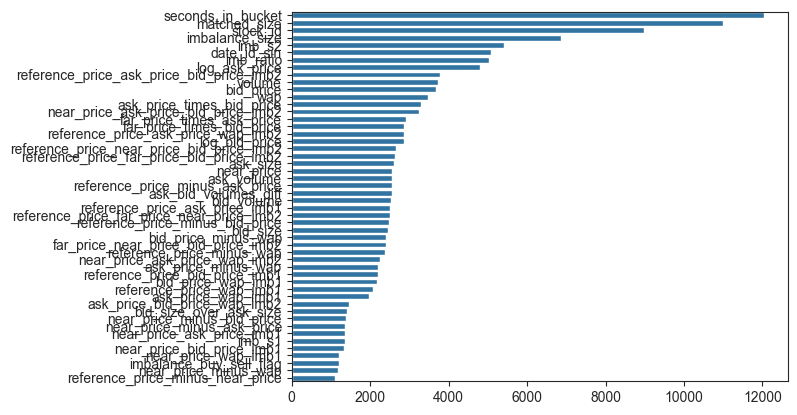

In [ ]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 12))
agreggated_feature_importances.plot(kind='barh')